In [2]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
   sys.path.append(project_root)

from source.utils.minio_helper import read_df_from_minio

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # Agar list panjang tidak terpotong

BUCKET_NAME = "mlbb-lakehouse"

In [7]:
print("📥 Loading Silver Data...")
df_draft = read_df_from_minio(BUCKET_NAME, "silver/silver_draft_heroes.parquet", file_format='parquet')
df_enriched = read_df_from_minio(BUCKET_NAME, "silver/silver_draft_enriched.parquet", file_format='parquet')
df_dq = read_df_from_minio(BUCKET_NAME, "silver/silver_data_quality.parquet", file_format='parquet')

print(f"1. Draft Heroes (Base): {df_draft.shape if df_draft is not None else 'Gagal'}")
print(f"2. Enriched Data: {df_enriched.shape if df_enriched is not None else 'Gagal'}")
print(f"3. Data Quality Issues: {df_dq.shape if df_dq is not None else '0 Issues (Perfect)'}")

📥 Loading Silver Data...
[MINIO] Error Read: silver/silver_data_quality.parquet: S3 operation failed; code: NoSuchKey, message: The specified key does not exist., resource: /mlbb-lakehouse/silver/silver_data_quality.parquet, request_id: 1882F2489C323CAE, host_id: dd9025bab4ad464b049177c95eb6ebf374d3b3fd1af9251148b658df7ac2e3e8, bucket_name: mlbb-lakehouse, object_name: silver/silver_data_quality.parquet
1. Draft Heroes (Base): (8276, 11)
2. Enriched Data: (8276, 21)
3. Data Quality Issues: 0 Issues (Perfect)


In [11]:
print(df_draft.head())

   match_id region  tournament team_side team_name phase  order  \
0         1     ID  MPL ID S16      left  ONICONIC  pick      1   
1         1     ID  MPL ID S16      left  ONICONIC  pick      2   
2         1     ID  MPL ID S16      left  ONICONIC  pick      3   
3         1     ID  MPL ID S16      left  ONICONIC  pick      4   
4         1     ID  MPL ID S16      left  ONICONIC  pick      5   

  hero_name_normalized  is_winner_team     source_file          ingested_at  
0                 cici            True  mpl_id_s16.csv  2025-12-20 22:11:18  
1                  joy            True  mpl_id_s16.csv  2025-12-20 22:11:18  
2               pharsa            True  mpl_id_s16.csv  2025-12-20 22:11:18  
3               claude            True  mpl_id_s16.csv  2025-12-20 22:11:18  
4                hylos            True  mpl_id_s16.csv  2025-12-20 22:11:18  


In [12]:
df_draft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   match_id              8276 non-null   int64 
 1   region                8276 non-null   object
 2   tournament            8276 non-null   object
 3   team_side             8276 non-null   object
 4   team_name             8276 non-null   object
 5   phase                 8276 non-null   object
 6   order                 8276 non-null   int64 
 7   hero_name_normalized  8276 non-null   object
 8   is_winner_team        8276 non-null   bool  
 9   source_file           8276 non-null   object
 10  ingested_at           8276 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 654.8+ KB


In [14]:
print(df_draft.groupby("match_id").size().describe())

count    414.000000
mean      19.990338
std        0.097937
min       19.000000
25%       20.000000
50%       20.000000
75%       20.000000
max       20.000000
dtype: float64


In [15]:
print(df_draft["hero_name_normalized"].value_counts().head(10))

hero_name_normalized
zhuxin       379
baxia        373
wanwan       351
cici         340
yisunshin    336
lancelot     334
fanny        326
kalea        322
harith       299
arlott       287
Name: count, dtype: int64


In [17]:
print(df_enriched[
   ["hero_name_normalized", "win_rate", "tier_score", "counter_score"]
].head(10))

  hero_name_normalized  win_rate  tier_score  counter_score
0                 cici     50.48           4           0.68
1                  joy     51.36           2           0.00
2               pharsa     49.17           1           0.00
3               claude     52.40           0           0.00
4                hylos     50.44           1           0.00
5               wanwan     49.41           1           0.00
6            yisunshin     52.79           5           0.00
7                fanny     44.26           3           0.00
8               selena     47.01           0           0.00
9               uranus     50.66           1           0.00


In [19]:
df_enriched_raw = df_enriched.replace(0, None)

print(df_enriched_raw.isnull().mean())

match_id                0.000000
region                  0.000000
tournament              0.000000
team_side               0.000000
team_name               0.000000
phase                   0.000000
order                   0.000000
hero_name_normalized    0.000000
is_winner_team          0.000000
source_file             0.000000
ingested_at             0.000000
win_rate                0.000000
pick_rate               0.000000
ban_rate                0.000000
role                    0.000000
lane                    0.000000
speciality              0.000000
tier_score              0.105607
score                   0.000000
counter_score           0.860802
processed_at            0.000000
dtype: float64


In [21]:
print(df_enriched[df_enriched["phase"] == "pick"]["counter_score"].describe())

count    4139.000000
mean        0.156001
std         0.400757
min         0.000000
25%         0.000000
50%         0.000000
75%         0.050000
max         4.620000
Name: counter_score, dtype: float64


<Axes: >

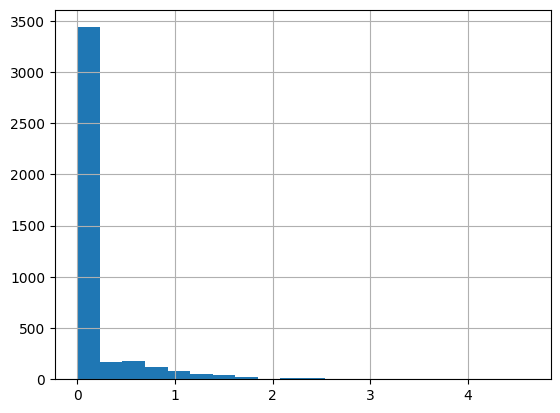

In [22]:
df_enriched[df_enriched["phase"] == "pick"]["counter_score"].hist(bins=20)

In [23]:
sample_match = df_enriched[df_enriched["match_id"] == 1]

print(sample_match[
   ["team_side", "phase", "hero_name_normalized", "counter_score"]
])

   team_side phase hero_name_normalized  counter_score
0       left  pick                 cici           0.68
1       left  pick                  joy           0.00
2       left  pick               pharsa           0.00
3       left  pick               claude           0.00
4       left  pick                hylos           0.00
5       left   ban               wanwan           0.00
6       left   ban            yisunshin           0.00
7       left   ban                fanny           0.00
8       left   ban               selena           0.00
9       left   ban               uranus           0.00
10     right  pick            esmeralda           0.00
11     right  pick             lancelot           0.00
12     right  pick              helcurt           0.00
13     right  pick               harith           0.00
14     right  pick            gatotkaca           0.00
15     right   ban               zhuxin           0.00
16     right   ban                kalea           0.00
17     rig

In [24]:
print(df_enriched.groupby(["match_id", "team_side"])["is_winner_team"].mean().head())

match_id  team_side
1         left         1.0
          right        0.0
2         left         1.0
          right        0.0
3         left         0.0
Name: is_winner_team, dtype: float64


In [25]:
if df_dq is not None:
   df_dq["issue_type"].value_counts()